By: Ali Vakilimafakheri, Eric Wang, Mac Kul

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
import seaborn as sns
import statistics as stat

In [22]:
final_df = pd.read_csv('/content/drive/MyDrive/PSTAT197Project/F21_190DD197A_Project/final_dataframe_final.csv')
final_df

,geo_value,time_value,geo_type,smoothed hospital admissions t-2,smoothed hospital admissions t-1,smoothed doctor visits t-2,smoothed doctor visits t-1,smoothed outpatient t-2,smoothed outpatient t-1,# restaurant visits t-2,# restaurant visits t-1,smoothed facebook survey t-2,smoothed facebook survey t-1,ground truth cases
0,6001,2020-04-22,county,2.234519,1.770617,2.767596,3.155609,1.656988,1.717308,357.727138,380.727818,0.649220,0.676449,2.453138
1,6013,2020-04-22,county,0.175260,0.176625,1.453058,1.344591,0.771173,0.789292,431.265364,394.264365,0.470025,0.408881,1.213670
2,6019,2020-04-22,county,3.851377,3.851377,1.949906,1.809190,1.178094,1.249541,301.833311,349.534288,0.533601,0.683509,1.301170
3,6029,2020-04-22,county,6.347009,6.347009,5.051110,4.752964,1.710528,1.587731,370.575785,393.570022,0.851085,0.841763,1.333034
4,6037,2020-04-22,county,8.220279,8.160500,2.448907,2.953889,1.590533,1.629189,3907.282721,4121.183589,0.683543,0.665833,12.899554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,6079,2020-11-30,county,5.753926,6.326789,8.036469,8.064670,13.382713,11.734021,84.737626,77.722097,0.798893,0.782420,64.285740
4010,6081,2020-11-30,county,5.757647,5.529899,12.477722,12.982818,11.925645,11.231878,346.334682,270.476961,0.361789,0.501213,40.439723
4011,6085,2020-11-30,county,4.565513,4.626410,25.244551,23.430810,23.457361,20.588351,1284.781150,1069.646851,0.649258,0.741493,41.133863
4012,6099,2020-11-30,county,2.390781,3.619194,13.739118,13.923038,8.730182,8.435988,694.402426,586.562521,0.796759,0.962908,81.356917


In [27]:
final_df = final_df[final_df['ground truth cases']>=0]
final_df = final_df[final_df['ground truth cases']>0]
final_df

,geo_value,time_value,geo_type,smoothed hospital admissions t-2,smoothed hospital admissions t-1,smoothed doctor visits t-2,smoothed doctor visits t-1,smoothed outpatient t-2,smoothed outpatient t-1,# restaurant visits t-2,# restaurant visits t-1,smoothed facebook survey t-2,smoothed facebook survey t-1,ground truth cases
0,6001,2020-04-22,county,2.234519,1.770617,2.767596,3.155609,1.656988,1.717308,357.727138,380.727818,0.649220,0.676449,2.453138
1,6013,2020-04-22,county,0.175260,0.176625,1.453058,1.344591,0.771173,0.789292,431.265364,394.264365,0.470025,0.408881,1.213670
2,6019,2020-04-22,county,3.851377,3.851377,1.949906,1.809190,1.178094,1.249541,301.833311,349.534288,0.533601,0.683509,1.301170
3,6029,2020-04-22,county,6.347009,6.347009,5.051110,4.752964,1.710528,1.587731,370.575785,393.570022,0.851085,0.841763,1.333034
4,6037,2020-04-22,county,8.220279,8.160500,2.448907,2.953889,1.590533,1.629189,3907.282721,4121.183589,0.683543,0.665833,12.899554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,6079,2020-11-30,county,5.753926,6.326789,8.036469,8.064670,13.382713,11.734021,84.737626,77.722097,0.798893,0.782420,64.285740
4010,6081,2020-11-30,county,5.757647,5.529899,12.477722,12.982818,11.925645,11.231878,346.334682,270.476961,0.361789,0.501213,40.439723
4011,6085,2020-11-30,county,4.565513,4.626410,25.244551,23.430810,23.457361,20.588351,1284.781150,1069.646851,0.649258,0.741493,41.133863
4012,6099,2020-11-30,county,2.390781,3.619194,13.739118,13.923038,8.730182,8.435988,694.402426,586.562521,0.796759,0.962908,81.356917


In [24]:
#Function to Separate the Data by County and Create X,y
def get_county_data(alldata, county_fip):
  County_df = alldata[alldata['geo_value']==county_fip]
  County_df = County_df.to_numpy()
  County_df_X = County_df[:,:-1]
  County_df_y = abs(County_df[:,-1])
  return County_df_X,County_df_y

In [9]:
#Fucntion that runs 5-fold CV on non Poly SVRs
def SVR_cv_nopoly(X_train, y_train):
  Kernels = ['rbf','sigmoid']
  C = []
  C = np.arange(1.0,5.0,0.1) 
  CrossVal = {'Kernel':[],'C':[],'Train':[],'Test':[]}

  for k in Kernels:
    for c in C:
      svr = SVR(kernel=k, C=c)
      cv = cross_validate(svr,X_train, y_train,cv=5,return_train_score=True,scoring='neg_mean_squared_error')
      CrossVal['Kernel'].append(k)
      CrossVal['C'].append(c)
      CrossVal['Train'].append(stat.mean(cv['train_score']))
      CrossVal['Test'].append(stat.mean(cv['test_score']))

  CrossVal = pd.DataFrame(CrossVal)
        
  return CrossVal  


In [10]:
#Function that runs 5-fold CV on Poly SVRs only
def SVR_cv_poly(X_train, y_train):
  Deg = [2,3,4,5,6,7,8,9,10]
  Coef = []
  Coef = np.arange(0,1,0.1)
  C = []
  C = np.arange(1.0,5.0,0.1)

  CrossVal_poly = {'Degree':[],'C':[],'Coef':[],'Train':[],'Test':[]}
  

  for d in Deg:
    for c in C:
      for coef in Coef:
        svr = SVR(kernel='poly', degree=d, C=c,coef0=coef)
        cv = cross_validate(svr,X_train, y_train,cv=5,return_train_score=True,scoring='neg_mean_squared_error')
        CrossVal_poly['Degree'].append(d)
        CrossVal_poly['C'].append(c)
        CrossVal_poly['Coef'].append(coef)
        CrossVal_poly['Train'].append(stat.mean(cv['train_score']))
        CrossVal_poly['Test'].append(stat.mean(cv['test_score']))


  CrossVal_poly = pd.DataFrame(CrossVal_poly)
        
  return CrossVal_poly  

In [11]:
#Function to fit and test a non Poly SVR
def SVR_pred_nopoly(X_train,y_train,X_test,y_test,kern,C):
  svr = SVR(kernel=kern,C=C)
  svr.fit(X_train,y_train)
  preds = svr.predict(X_test)
  r2 = mean_squared_error(y_test,preds)
  return preds,r2

In [12]:
#Function to fit and test a Poly SVR
def SVR_pred_poly(X_train,y_train,X_test,y_test,degree,C,coef):
  svr = SVR(kernel='poly',degree=degree,coef0=coef, C=C)
  svr.fit(X_train,y_train)
  preds = svr.predict(X_test)
  r2 = mean_squared_error(y_test,preds)
  return preds,r2

In [13]:
#Function to Split the Data into train and test sets
def data_splits(X,y):
  County_X_train,County_X_test,County_y_train,\
  County_y_test=train_test_split(X,y,train_size=0.7,shuffle=False)
  Train_Dates = County_X_train[:,1]
  Test_Dates = County_X_test[:,1]
  Train_Dates = Train_Dates.astype(np.datetime64)
  Test_Dates = Test_Dates.astype(np.datetime64)
  County_X_train_nodates = County_X_train[:,3:]
  County_X_test_nodates = County_X_test[:,3:]
  return County_X_train_nodates,County_X_test_nodates,County_y_train,County_y_test,Train_Dates,Test_Dates

In [30]:
#Normalize and Standardize Features
def norma(X_train, X_test):
  sc = StandardScaler()
  X_train = normalize(X_train,axis=0)
  X_test = normalize(X_test,axis=0)
  X_train = sc.fit_transform(X_train)
  X_test = sc.fit_transform(X_test)
  return X_train,X_test


In [15]:
#Get Plotting Data
def plotdata(Test_Dates,predictions,ground_truth):
  temp = np.column_stack((ground_truth,predictions))
  temp_dates = np.column_stack((Test_Dates,temp))
  temp_dates = pd.DataFrame(temp_dates)
  return temp_dates

In [16]:
#Function to fit and test LR
def LR(X_train, y_train, X_test, y_test):
  LR = LinearRegression()
  LR.fit(X_train,y_train)
  preds = LR.predict(X_test)
  r2 = mean_squared_error(y_test,preds)
  return preds,r2

In [17]:
#Function to Plot Sigmoid SVR
def plotsig(CrossValData,fip):
  fip = fip
  sig = CrossValData[CrossValData['Kernel']=='sigmoid']
  sig_train = sig['Train']
  sig_test = sig['Test']
  sig_c = sig['C']
  plt.plot(sig_c,sig_train,color='black',label='Train')
  plt.plot(sig_c,sig_test,color='blue',label='Validation')
  plt.gca().invert_xaxis()
  plt.xlabel('C')
  plt.ylabel('Neg_Mean_Squared_Error')
  plt.title('Sigmoid Kernel With Different C Values County %f'%fip)
  plt.legend()
  plt.savefig('CountySig%f.jpg' %fip)
  plt.show()

In [18]:
#Function to Plot rbf SVR
def plotrbf(CrossValData,fip):
  fip = fip
  sig = CrossValData[CrossValData['Kernel']=='rbf']
  sig_train = sig['Train']
  sig_test = sig['Test']
  sig_c = sig['C']
  plt.plot(sig_c,sig_train,color='black',label='Train')
  plt.plot(sig_c,sig_test,color='blue',label='Validation')
  #plt.gca().invert_xaxis()
  plt.xlabel('C')
  plt.ylabel('Neg_Mean_Squared_Error')
  plt.title('rbf Kernel With Different C Values County %f'%fip)
  plt.legend()
  plt.savefig('Countyrbf%f.jpg' %fip)
  plt.show()

In [19]:
#Function to Plot Poly SVR
def plotpoly(CrossValData,fip):
  fip = fip
  Degree = [2,3,4,5,6,7,8,9,10]
  PolyGD={'Degree':[],'Train':[],'Test':[]}
  for deg in Degree:
    temp = CrossValData[CrossValData['Degree']==deg]
    temp_train = temp['Train']
    temp_train = stat.mean(temp_train)
    temp_test = temp['Test']
    temp_test = stat.mean(temp_test)
    PolyGD['Degree'].append(deg)
    PolyGD['Train'].append(temp_train)
    PolyGD['Test'].append(temp_test)
  plt.plot(PolyGD['Degree'],PolyGD['Train'],color='black',label='Train')
  plt.plot(PolyGD['Degree'],PolyGD['Test'],color='blue',label='Validation')
  plt.gca().invert_xaxis()
  plt.xlabel('Degree')
  plt.ylabel('Neg_Mean_Squared_Error')
  plt.title('Poly Kerner With Different Degrees County %f' %fip)
  plt.legend()
  plt.savefig('CountyPoly%f.jpg' %fip)
  plt.show()

In [28]:
lr = LinearRegression()

The MSE for Linear Regression of County 6001 is: 565532.8242474211
Weights and Intercept: [-0.39096367  2.17700501 -4.69457255  3.61073077 -0.00587671  4.39859813
 -1.16206654  0.30444391 -0.77314928  1.97689391] 8.222415282250706


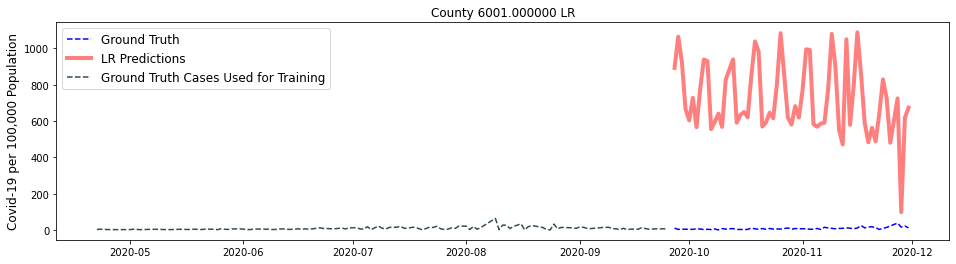

The MSE for Linear Regression of County 6013 is: 3594855.2098571137
Weights and Intercept: [ 4.31339791 -3.78240775 -4.52416186  5.83618331  7.69226779 -6.40744006
  0.61514753  1.37771002  1.71150246  1.05265115] 8.971054290040628


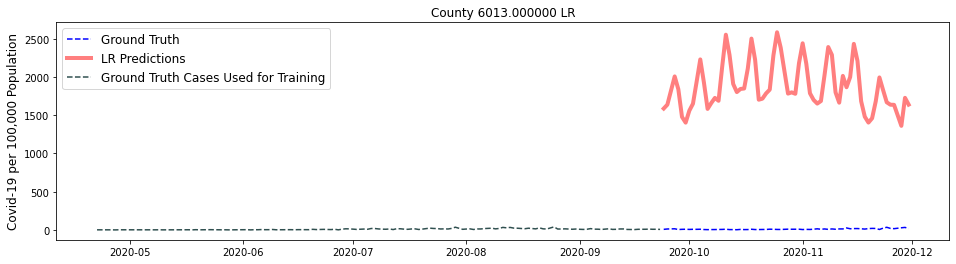

The MSE for Linear Regression of County 6019 is: 664084.8644523585
Weights and Intercept: [  8.03890858  -4.88552051   3.22616692  -2.38528463  34.79316682
 -27.01761063   3.83269524  -3.27240245   6.12867667  -0.32828028] 21.712319375118167


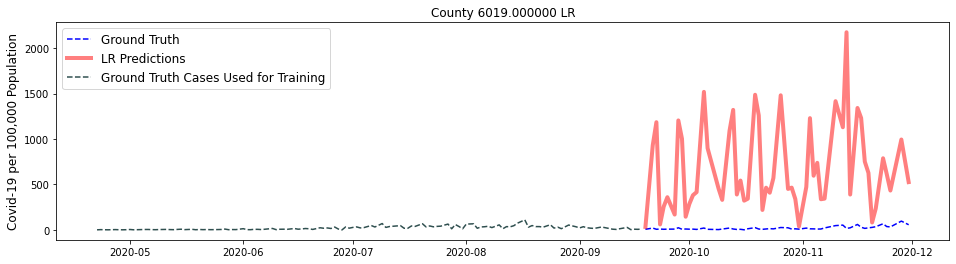

The MSE for Linear Regression of County 6029 is: 10800154.034971692
Weights and Intercept: [  9.61236057  -9.35061146   4.85574135 -17.88580961  48.11199596
 -24.20949223   2.11363975  -6.45980581  14.82538928  -5.24625132] 22.940036421455034


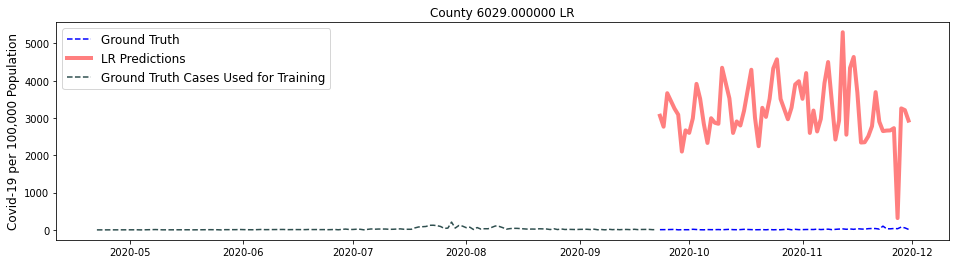

The MSE for Linear Regression of County 6037 is: 752762330.2447336
Weights and Intercept: [ 0.01870177  0.81397752 -0.80019462  0.23695823 -0.37879756  9.57438218
 -3.99955655  0.77850642  0.2756704  -0.21185869] 16.481744840452457


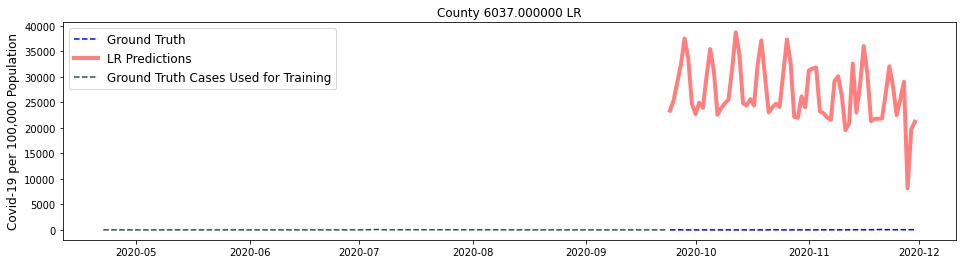

The MSE for Linear Regression of County 6041 is: 1437801.4413899435
Weights and Intercept: [-131.76211825  143.03578817    1.93827938    8.64309269    3.73197904
  -15.4680113    10.64283984   11.83848485    2.84418479  -15.98312305] 24.59181071394605


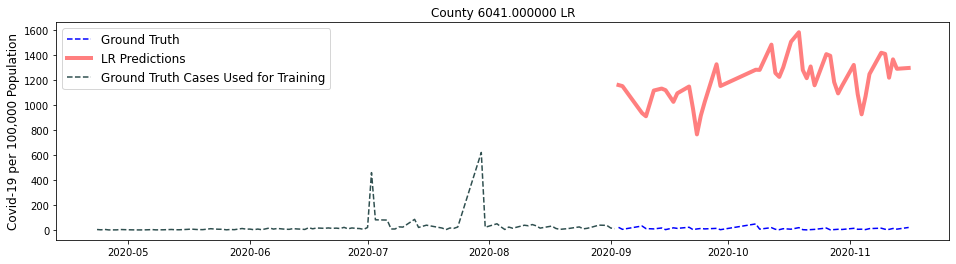

The MSE for Linear Regression of County 6059 is: 68261663.70067717
Weights and Intercept: [ -1.44570599   1.19770625  -0.48883929   0.10107348  20.54843591
 -12.04181422  -1.1871599   -0.20127423   0.05557068  -0.14500485] 10.437238417477493


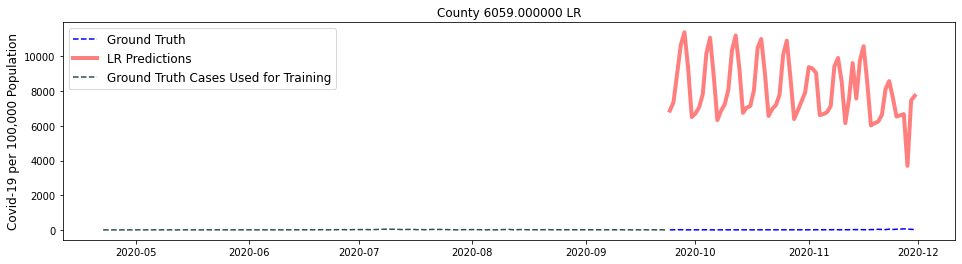

The MSE for Linear Regression of County 6061 is: 135910.13947084593
Weights and Intercept: [ 2.15857465 -2.11349297 -0.30378281  1.07017351 -0.60064556  3.42028955
  0.23434826  0.15439762 -0.01349366 -0.06741632] 6.1595899547525095


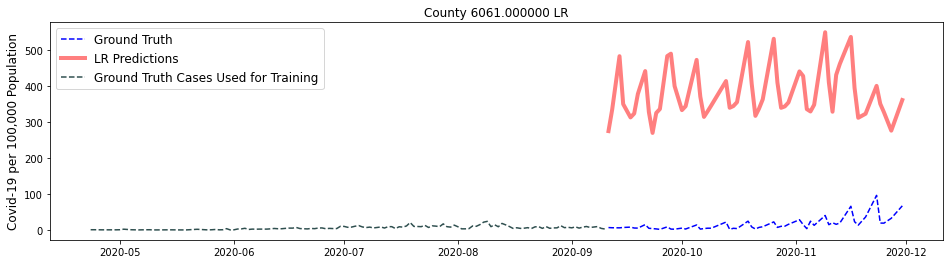

The MSE for Linear Regression of County 6065 is: 52632148.50597971
Weights and Intercept: [-1.69564236  1.97697337 -8.54937518  7.9830565  14.29240725 -5.05486317
  5.41120559 -4.11424303  3.68128866 -0.2827368 ] 18.66371450554387


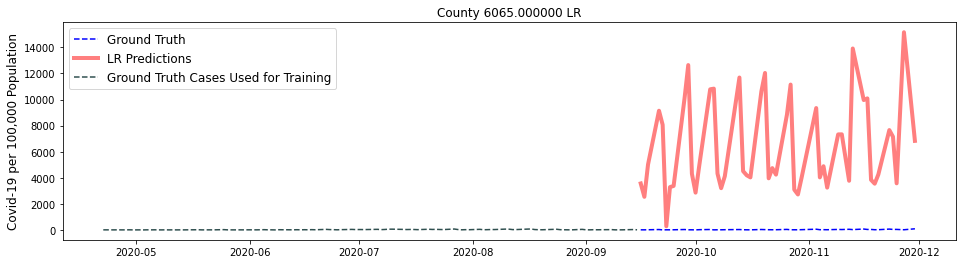

The MSE for Linear Regression of County 6067 is: 4246639.589596574
Weights and Intercept: [ -3.9316966    0.60760323 -10.21774817  11.15139859  -2.97997271
  13.67289213   5.1849354   -4.63331759   0.63166257  -2.15201908] 10.122356169014157


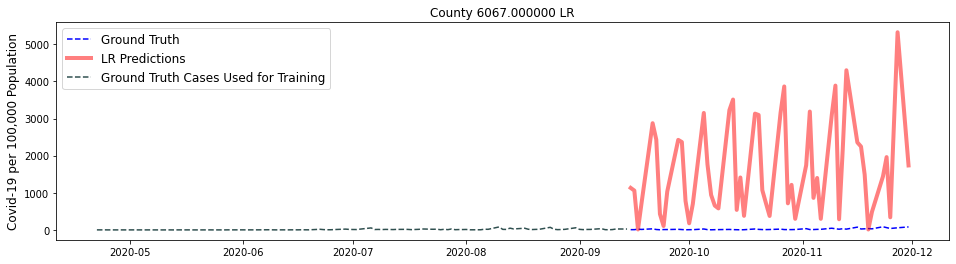

The MSE for Linear Regression of County 6071 is: 118918974.0376384
Weights and Intercept: [-11.2290211   16.7444202  -18.17415832  10.23414923   7.96579923
   5.37648628  -3.84913717   0.95740752   2.94418693  -2.74723791] 16.71779168962235


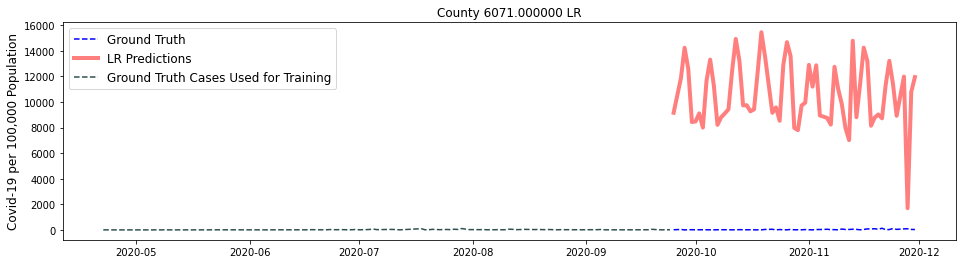

The MSE for Linear Regression of County 6073 is: 80958892.1250626
Weights and Intercept: [-0.68496857  2.40594034 -3.32310022  4.84293892 -3.60752873  4.27653918
  0.63840656  1.2554951   0.42561789 -0.6593311 ] 8.658653331716996


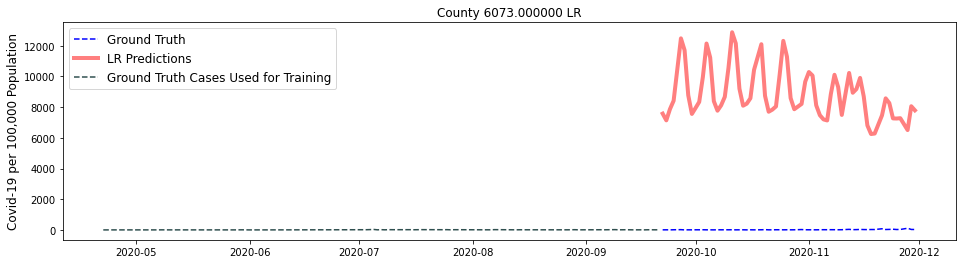

The MSE for Linear Regression of County 6075 is: 4009.5499818638955
Weights and Intercept: [ 1.57630892 -1.39618165  1.45757494 -0.01700078  7.99974519 -5.87074964
 -0.26512402  0.32599395 -0.03891321  0.78315844] 7.389590044666525


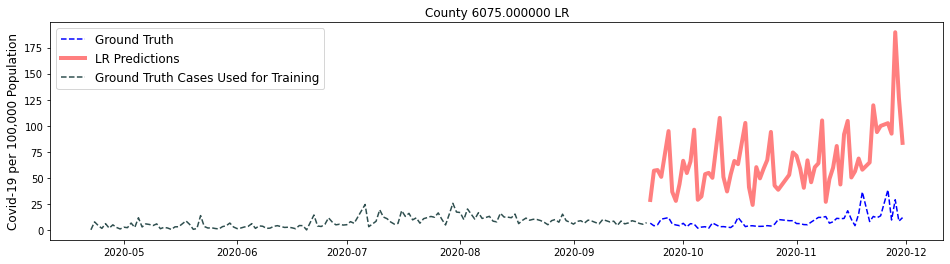

The MSE for Linear Regression of County 6079 is: 393065.2560747368
Weights and Intercept: [ 1.75959702  0.94906145  0.12937085  0.02500299 12.04573999 -8.99042954
  4.07952362  0.42279019 -1.5119393   1.9385872 ] 9.962649682582878


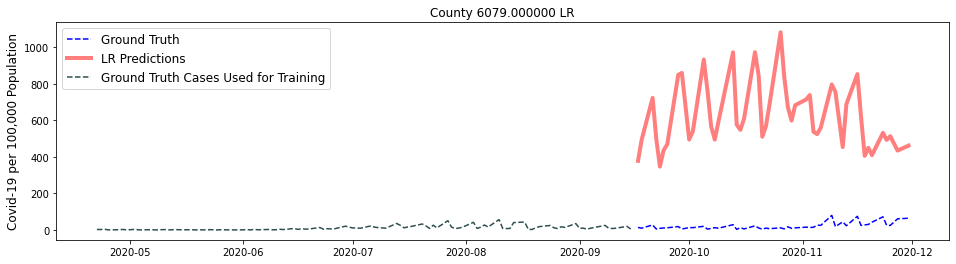

The MSE for Linear Regression of County 6081 is: 1503444.3489776477
Weights and Intercept: [ 1.65143687 -1.13683109  0.83582436 -0.6254519  -1.67735313  2.2060272
  2.68590697  1.02917706  0.36855065 -0.08500952] 9.257688719634066


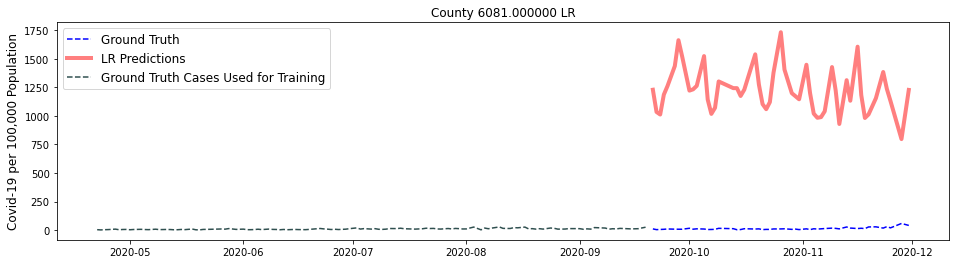

The MSE for Linear Regression of County 6085 is: 12488203.883033056
Weights and Intercept: [ 3.31329619 -3.07019949 -0.61431662  1.07264864 -3.09527263  4.14556996
  1.28727395  1.65243949  0.23239701  0.5810078 ] 6.465693768116878


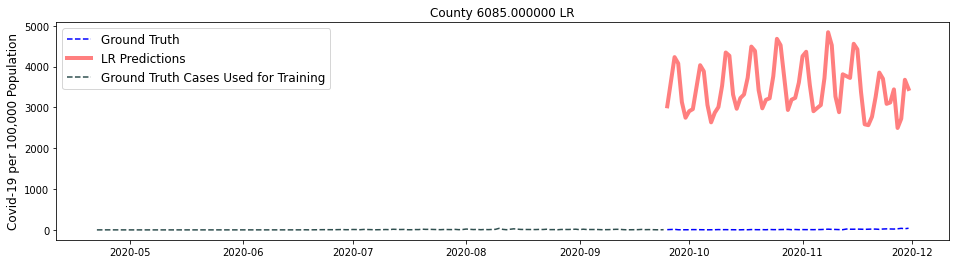

The MSE for Linear Regression of County 6099 is: 10665948.926881813
Weights and Intercept: [-15.63478801  12.97379537  -3.70018122   0.71361118  20.52730659
  -2.94713742  -7.74717259   3.01230397   0.80275405   1.87962607] 19.892691659174666


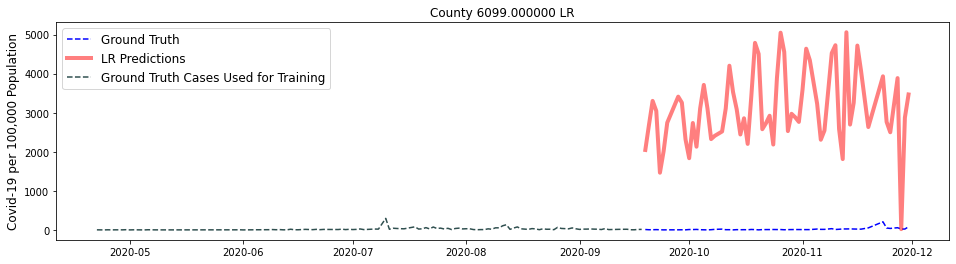

The MSE for Linear Regression of County 6111 is: 27664239.21380925
Weights and Intercept: [  9.44157039  -8.744922     3.93883873  -1.27705711  20.72410268
 -15.60402636   3.14797384   2.07037551   0.7467422    0.4579377 ] 13.838959933209571


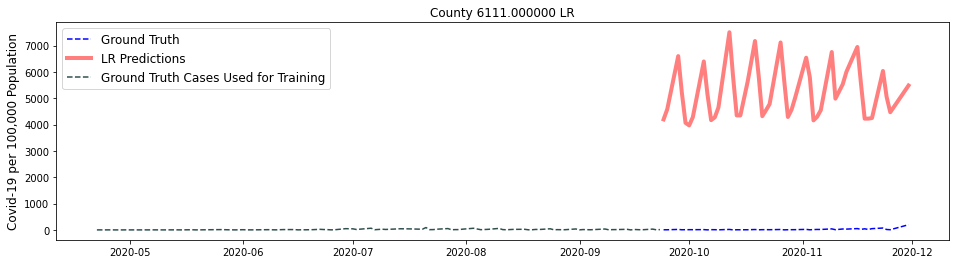

In [31]:
Counties = [6001,6013,6019,6029,6037,6041,6059,6061,6065,6067,6071,6073,6075,6079,6081,6085,6099,6111]
Counties = np.int64(Counties)
for fips in Counties:
  County_j_x, County_j_y = get_county_data(final_df, fips)
  County_j_X_train,County_j_X_test,County_j_y_train,\
  County_j_y_test,Train_Dates_j,Test_Dates_j = data_splits(County_j_x,County_j_y)
  County_j_X_train_norm,County_j_X_test_norm = norma(County_j_X_train,County_j_X_test)
  Preds_j,R2_j=LR(County_j_X_train_norm,County_j_y_train,County_j_X_test_norm,
                  County_j_y_test)
  lr.fit(County_j_X_train_norm,County_j_y_train)
  print("The MSE for Linear Regression of County", fips,"is:",R2_j)
  print("Weights and Intercept:",lr.coef_,lr.intercept_)
  MSE = str(R2_j)
  Predictions_and_Dates_j = plotdata(Test_Dates_j,Preds_j,County_j_y_test)
  fig, ax = plt.subplots(1, 1, figsize=(16, 4))
  ax.plot(Predictions_and_Dates_j[0],abs(Predictions_and_Dates_j[1]),color='blue',
          linestyle='dashed',label='Ground Truth')
  ax.plot(Predictions_and_Dates_j[0],abs(Predictions_and_Dates_j[2]),color='red',
          alpha=0.5,linewidth=4,label='LR Predictions')
  ax.plot(Train_Dates_j,County_j_y_train,color='darkslategray',linestyle='dashed',
          label='Ground Truth Cases Used for Training')
  ax.set_ylabel('Covid-19 per 100,000 Population',fontsize=12)
  ax.set_title('County %f LR' %fips,fontsize=12)
  ax.legend(prop={'size':12})
  plt.savefig('CountyLR%f.jpg' %fips)
  plt.show()

County 6001.000000
   Kernel    C      Train       Test
39    rbf  4.9 -48.319082 -53.407852
     Degree    C  Coef      Train       Test
499       3  1.9   0.9 -48.067528 -56.695425


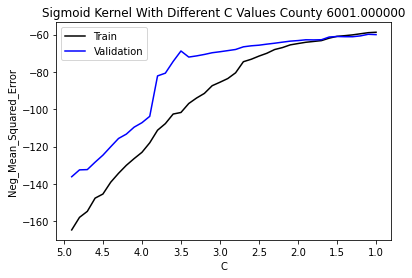

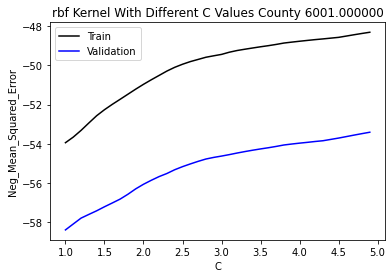

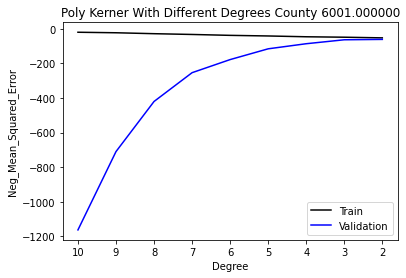

County 6013.000000
   Kernel    C      Train       Test
39    rbf  4.9 -19.231712 -36.453009
     Degree    C  Coef      Train       Test
714       3  4.1   0.4 -21.668014 -39.376458


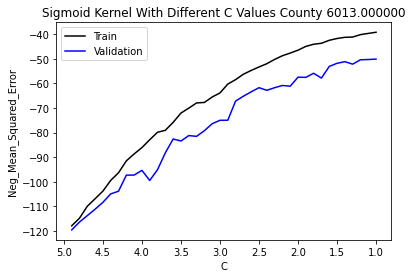

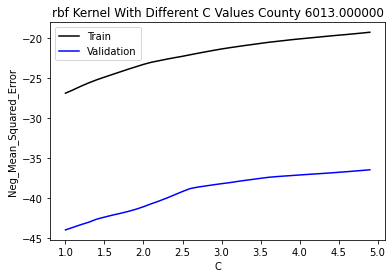

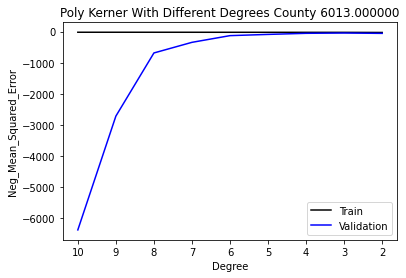

County 6019.000000
   Kernel    C       Train        Test
39    rbf  4.9 -225.151911 -305.941004
     Degree    C  Coef       Train        Test
799       3  4.9   0.9 -221.410085 -290.656368


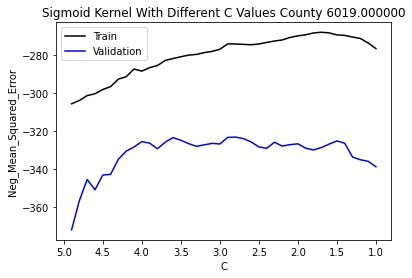

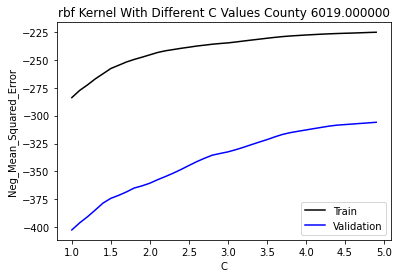

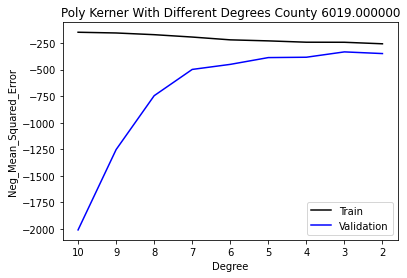

County 6029.000000
   Kernel    C       Train        Test
39    rbf  4.9 -545.603339 -738.310656
   Degree    C  Coef       Train        Test
4       2  1.0   0.4 -677.870168 -860.050757


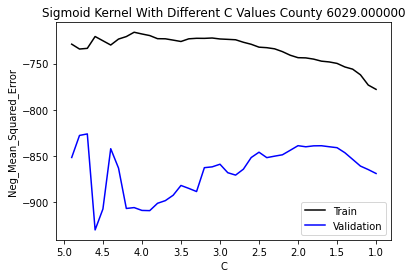

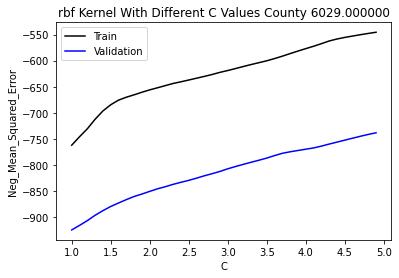

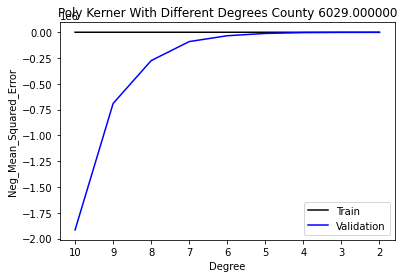

County 6037.000000
   Kernel    C      Train       Test
39    rbf  4.9 -59.908744 -92.819675
     Degree    C  Coef      Train      Test
429       3  1.2   0.9 -55.018424 -74.76865


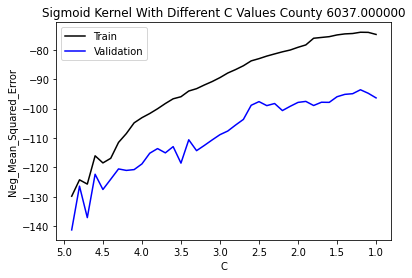

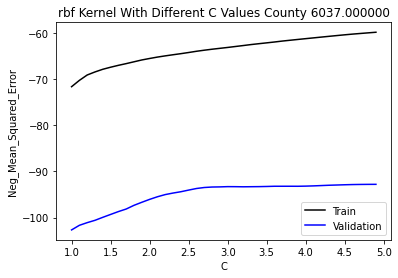

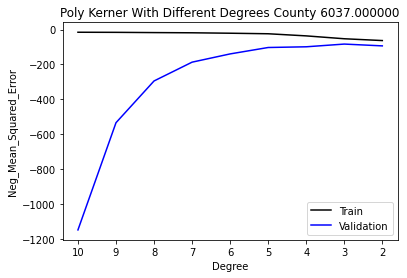

County 6041.000000
     Kernel    C        Train         Test
65  sigmoid  3.5 -3815.190671 -3801.282284
   Degree    C  Coef        Train        Test
9       2  1.0   0.9 -3799.113138 -3874.23615


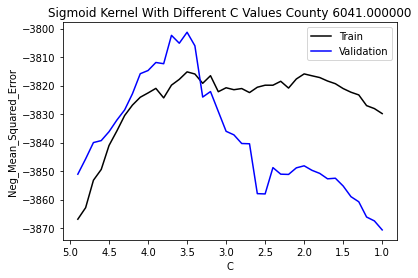

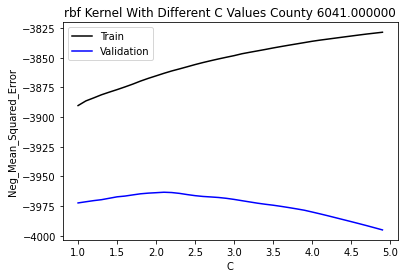

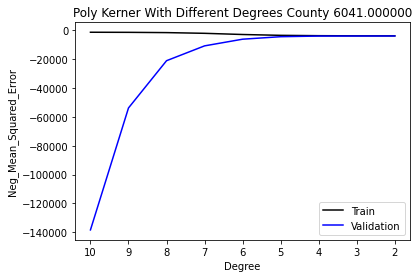

County 6059.000000
     Kernel    C      Train       Test
40  sigmoid  1.0 -42.822497 -64.287626
     Degree    C  Coef      Train       Test
400       3  1.0   0.0 -25.691336 -34.903856


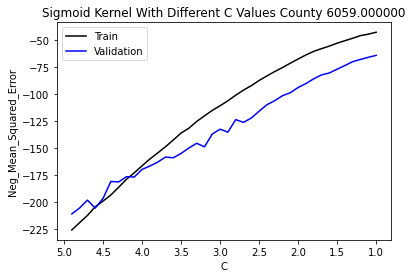

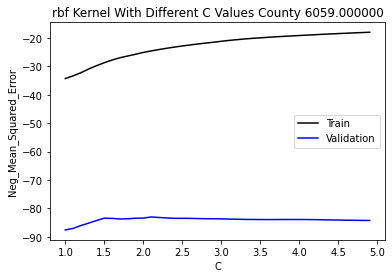

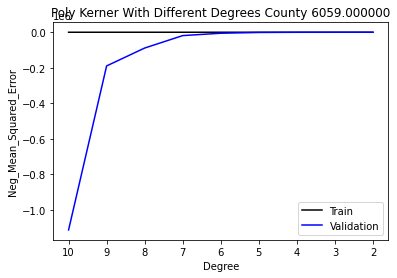

County 6061.000000
     Kernel    C      Train       Test
40  sigmoid  1.0 -13.160869 -15.040086
    Degree    C  Coef     Train       Test
81       2  1.8   0.1 -9.102086 -13.482439


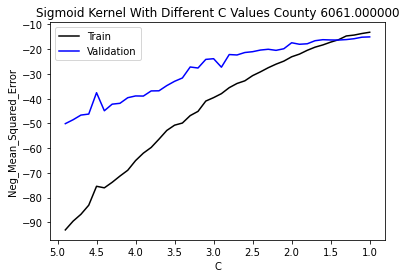

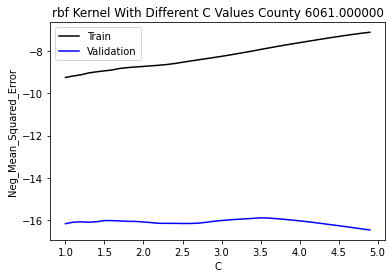

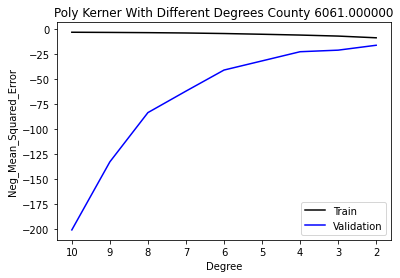

County 6065.000000
     Kernel    C       Train        Test
64  sigmoid  3.4 -216.612613 -199.483573
   Degree    C  Coef       Train        Test
9       2  1.0   0.9 -195.108468 -236.697217


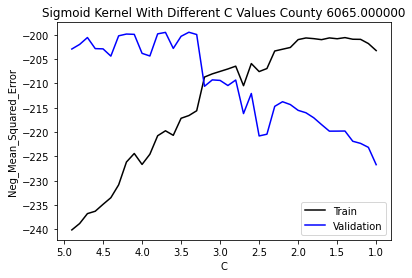

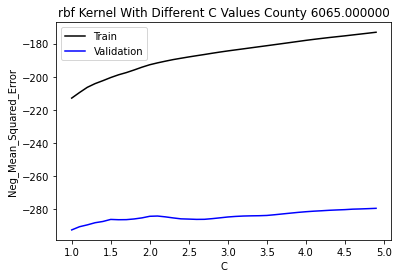

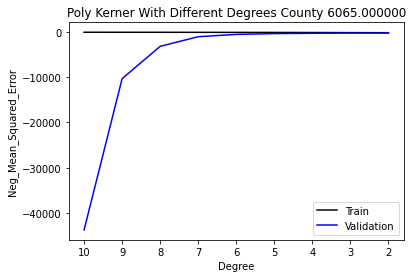

County 6067.000000
   Kernel    C       Train        Test
39    rbf  4.9 -118.932121 -133.289101
      Degree    C  Coef      Train        Test
1196       4  4.9   0.6 -87.765814 -122.583546


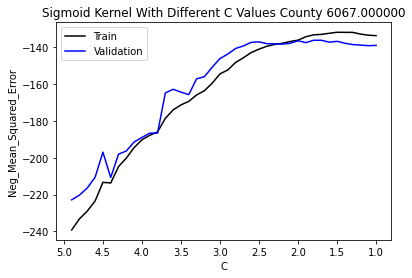

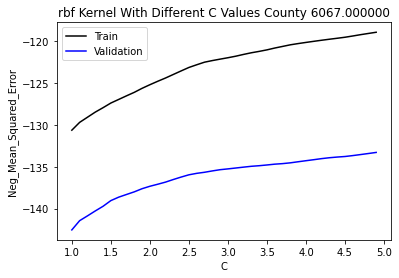

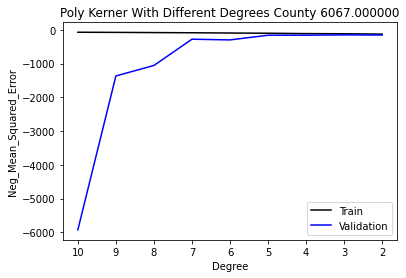

County 6071.000000
   Kernel    C      Train        Test
39    rbf  4.9 -161.10929 -191.380773
     Degree    C  Coef       Train        Test
499       3  1.9   0.9 -153.623078 -183.786921


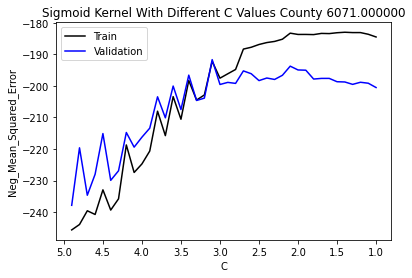

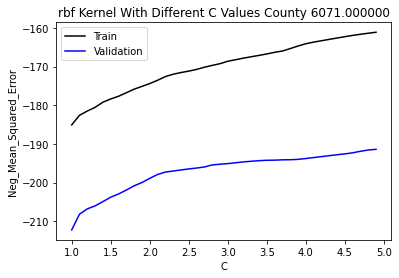

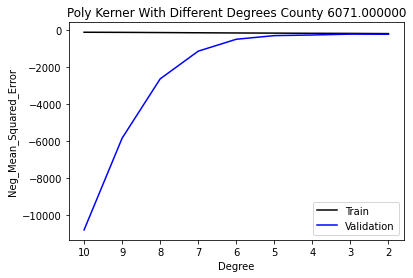

County 6073.000000
   Kernel    C     Train       Test
39    rbf  4.9 -9.893323 -25.603576
    Degree    C  Coef      Train       Test
29       2  1.2   0.9 -12.322699 -21.307956


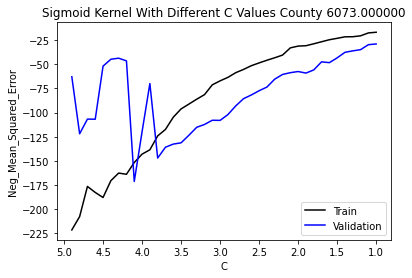

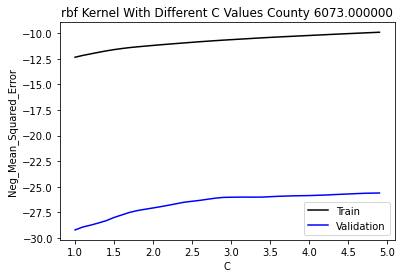

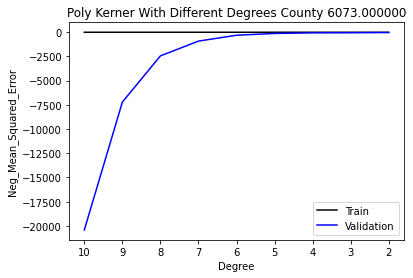

County 6075.000000
   Kernel    C      Train       Test
39    rbf  4.9 -12.474395 -18.269634
     Degree    C  Coef     Train       Test
419       3  1.1   0.9 -12.66716 -16.366007


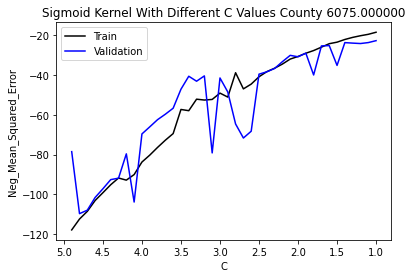

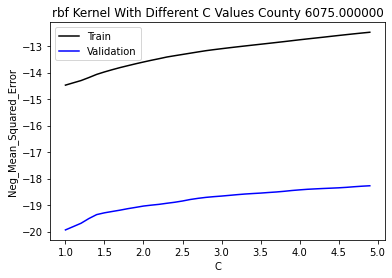

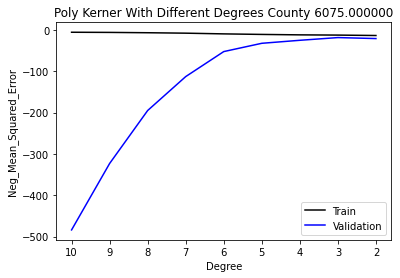

County 6079.000000
   Kernel    C      Train        Test
39    rbf  4.9 -86.621726 -116.524748
     Degree    C  Coef     Train        Test
396       2  4.9   0.6 -90.45398 -115.346396


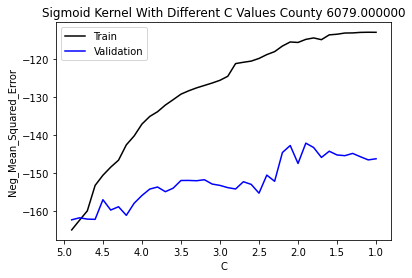

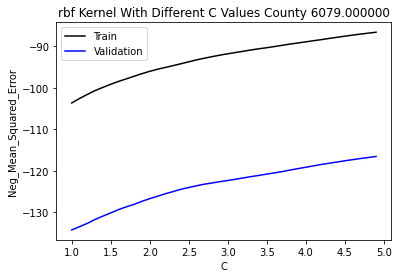

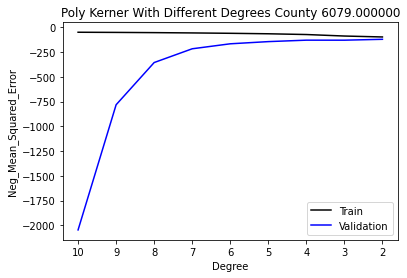

County 6081.000000
     Kernel    C      Train       Test
40  sigmoid  1.0 -31.617715 -31.927125
     Degree    C  Coef      Train       Test
520       3  2.2   0.0 -27.319016 -34.197539


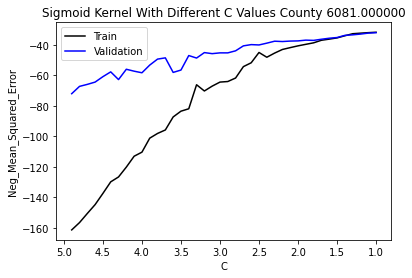

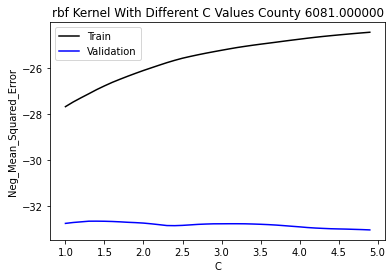

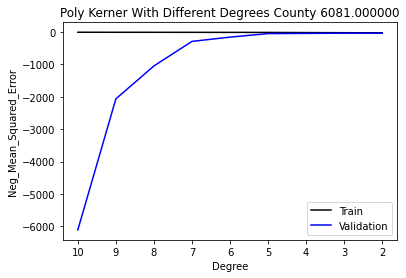

County 6085.000000
  Kernel    C      Train       Test
6    rbf  1.6 -15.988734 -24.610481
     Degree    C  Coef      Train       Test
406       3  1.0   0.6 -16.342663 -24.897169


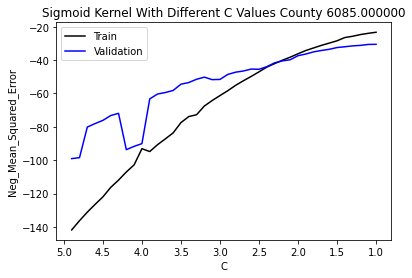

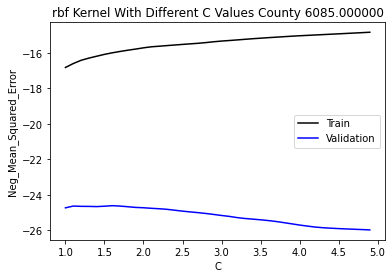

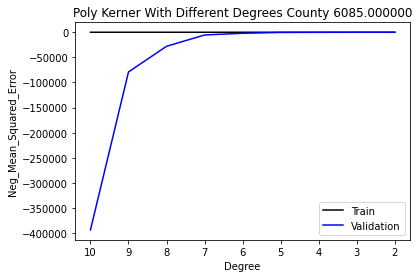

County 6099.000000
   Kernel    C       Train        Test
27    rbf  3.7 -755.041292 -829.914407
      Degree    C  Coef       Train       Test
2864       9  1.6   0.4 -647.205746 -771.42392


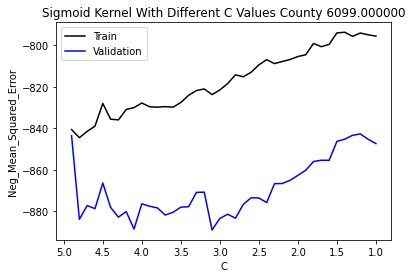

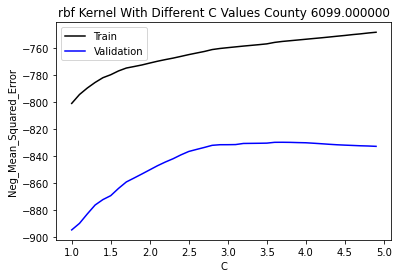

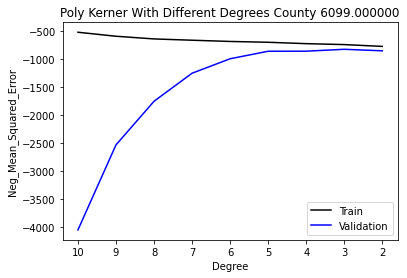

County 6111.000000
     Kernel    C       Train        Test
53  sigmoid  2.3 -226.811991 -219.818374
     Degree    C  Coef       Train      Test
847       4  1.4   0.7 -195.868316 -226.7972


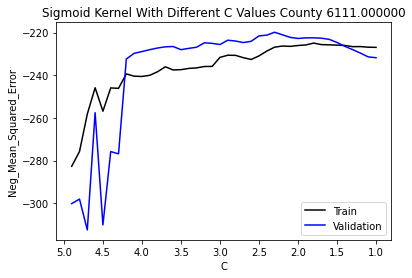

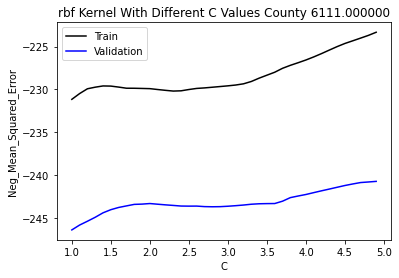

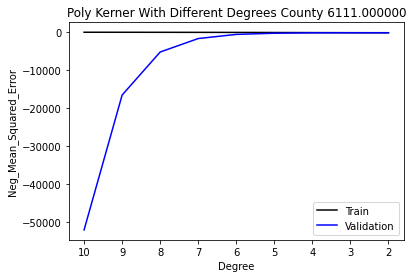

In [ ]:
Counties = [6001,6013,6019,6029,6037,6041,6059,6061,6065,6067,6071,6073,6075,6079,6081,6085,6099,6111]
Counties = np.int64(Counties)
for i in Counties:
  print('County %f' %i)
  County_6j_x, County_6j_y = get_county_data(final_df, i)
  County_6j_X_train,County_6j_X_test,County_6j_y_train,County_6j_y_test,Train_Dates_6j,\
  Test_Dates_6j = data_splits(County_6j_x,County_6j_y)
  County_6j_X_train_norm,County_6j_X_test_norm = norma(County_6j_X_train,County_6j_X_test)
  Cross_Val_6j_nopoly = SVR_cv_nopoly(County_6j_X_train_norm,County_6j_y_train)
  Cross_Val_6j_poly=SVR_cv_poly(County_6j_X_train_norm,County_6j_y_train)
  print(Cross_Val_6j_nopoly[Cross_Val_6j_nopoly['Test']==max(Cross_Val_6j_nopoly['Test'])])
  print(Cross_Val_6j_poly[Cross_Val_6j_poly['Test']==max(Cross_Val_6j_poly['Test'])])
  plotsig(Cross_Val_6j_nopoly,i)
  plotrbf(Cross_Val_6j_nopoly,i)
  plotpoly(Cross_Val_6j_poly,i)

The MSE of the rbf Kernel SVR for County 6001 is 41.11958138714088


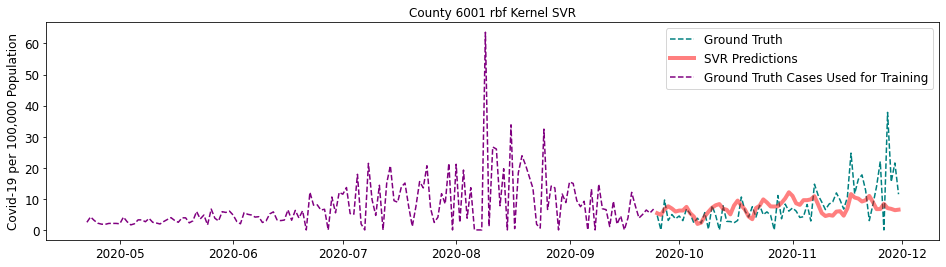

In [ ]:
County_6001_x, County_6001_y = get_county_data(final_df, 6001)
County_6001_X_train,County_6001_X_test,County_6001_y_train,County_6001_y_test,\
Train_Dates_6001,Test_Dates_6001 = data_splits(County_6001_x,County_6001_y)
County_6001_X_train_norm,County_6001_X_test_norm = norma(County_6001_X_train,County_6001_X_test)
Predictions_6001,MSE_6001 = SVR_pred_nopoly(County_6001_X_train_norm,County_6001_y_train,
                                           County_6001_X_test_norm,County_6001_y_test,'rbf',4.9)
print('The MSE of the rbf Kernel SVR for County 6001 is',MSE_6001)
Predictions_and_Dates_6001 = plotdata(Test_Dates_6001,Predictions_6001,County_6001_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.plot(Predictions_and_Dates_6001[0],Predictions_and_Dates_6001[1],
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6001[0],Predictions_and_Dates_6001[2],
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6001,County_6001_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
ax.set_title('County 6001 rbf Kernel SVR',fontsize=12)
ax.set_ylabel('Covid-19 per 100,000 Population',fontsize=12)
ax.tick_params('both',labelsize=12)
ax.legend(prop={'size':12})
plt.savefig('County6001SVR.jpg' )
plt.show()

The MSE of the rbf Kernel SVR for County 6013 is 39.48810150102513


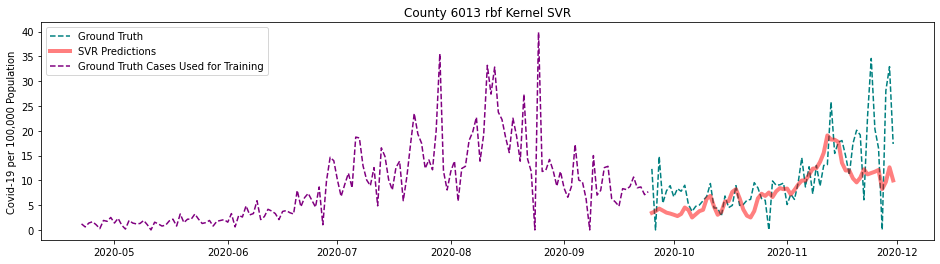

In [ ]:
County_6013_x, County_6013_y = get_county_data(final_df, 6013)
County_6013_X_train,County_6013_X_test,County_6013_y_train,County_6013_y_test,\
Train_Dates_6013,Test_Dates_6013 = data_splits(County_6013_x,County_6013_y)
County_6013_X_train_norm,County_6013_X_test_norm = norma(County_6013_X_train,County_6013_X_test)
Predictions_6013,MSE_6013 = SVR_pred_nopoly(County_6013_X_train_norm,County_6013_y_train,
                                           County_6013_X_test_norm,County_6013_y_test,'rbf',4.9)
print('The MSE of the rbf Kernel SVR for County 6013 is',MSE_6013)
Predictions_and_Dates_6013 = plotdata(Test_Dates_6013,Predictions_6013,County_6013_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6013[0],abs(Predictions_and_Dates_6013[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6013[0],abs(Predictions_and_Dates_6013[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6013,County_6013_y_train,color='purple',
        linestyle='dashed', label='Ground Truth Cases Used for Training')
plt.title('County 6013 rbf Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6013SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6019 is 300.02581414546944


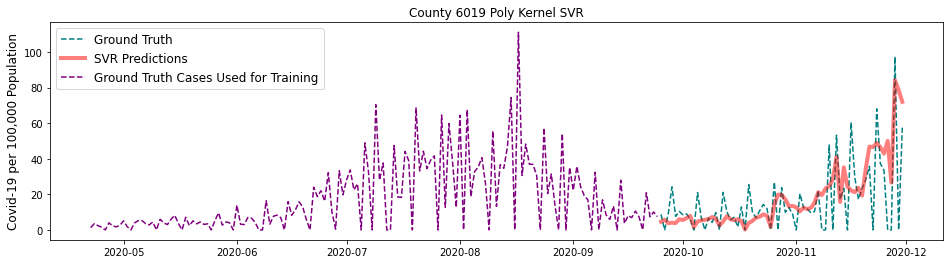

In [ ]:
County_6019_x, County_6019_y = get_county_data(final_df, 6019)
County_6019_X_train,County_6019_X_test,County_6019_y_train,County_6019_y_test,\
Train_Dates_6019,Test_Dates_6019 = data_splits(County_6019_x,County_6019_y)
County_6019_X_train_norm,County_6019_X_test_norm = norma(County_6019_X_train,County_6019_X_test)
Predictions_6019,MSE_6019 = SVR_pred_poly(County_6019_X_train_norm,County_6019_y_train,
                                         County_6019_X_test_norm,County_6019_y_test,3,4.9,0.9)
print('The MSE of the Poly Kernel SVR for County 6019 is',MSE_6019)
Predictions_and_Dates_6019 = plotdata(Test_Dates_6019,Predictions_6019,County_6019_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6019[0],abs(Predictions_and_Dates_6019[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6019[0],abs(Predictions_and_Dates_6019[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6019,County_6019_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
ax.set_title('County 6019 Poly Kernel SVR', fontsize=12)
ax.set_ylabel('Covid-19 per 100,000 Population',fontsize=12)
ax.legend(prop={'size':12})
plt.savefig('County6019SVR.jpg')
plt.show()

The MSE of the rbf Kernel SVR for County 6029 is 246.32555256948996


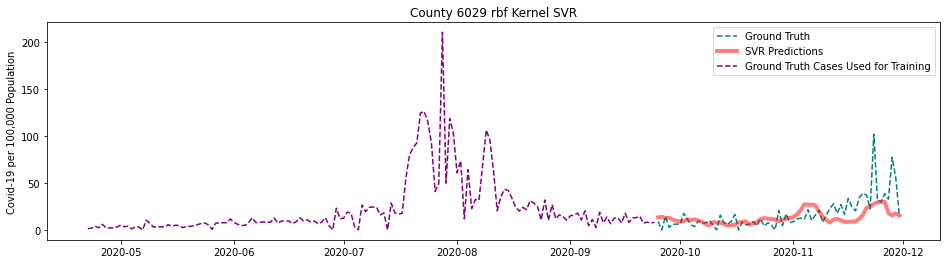

In [ ]:
County_6029_x, County_6029_y = get_county_data(final_df, 6029)
County_6029_X_train,County_6029_X_test,County_6029_y_train,County_6029_y_test,\
Train_Dates_6029,Test_Dates_6029 = data_splits(County_6029_x,County_6029_y)
County_6029_X_train_norm,County_6029_X_test_norm = norma(County_6029_X_train,County_6029_X_test)
Predictions_6029,MSE_6029 = SVR_pred_nopoly(County_6029_X_train_norm,County_6029_y_train,
                                           County_6029_X_test_norm,County_6029_y_test,'rbf',4.9)
print('The MSE of the rbf Kernel SVR for County 6029 is',MSE_6029)
Predictions_and_Dates_6029 = plotdata(Test_Dates_6029,Predictions_6029,County_6029_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6029[0],abs(Predictions_and_Dates_6029[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6029[0],abs(Predictions_and_Dates_6029[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6029,County_6029_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6029 rbf Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6029SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6037 is 182.39892968008257


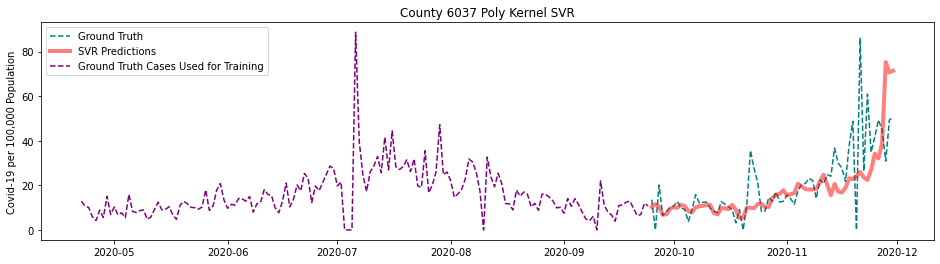

In [ ]:
County_6037_x, County_6037_y = get_county_data(final_df, 6037)
County_6037_X_train,County_6037_X_test,County_6037_y_train,County_6037_y_test,\
Train_Dates_6037,Test_Dates_6037 = data_splits(County_6037_x,County_6037_y)
County_6037_X_train_norm,County_6037_X_test_norm = norma(County_6037_X_train,County_6037_X_test)
Predictions_6037,MSE_6037 = SVR_pred_poly(County_6037_X_train_norm,County_6037_y_train,
                                         County_6037_X_test_norm,County_6037_y_test,3,1.2,0.9)
print('The MSE of the Poly Kernel SVR for County 6037 is',MSE_6037)
Predictions_and_Dates_6037 = plotdata(Test_Dates_6037,Predictions_6037,County_6037_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6037[0],abs(Predictions_and_Dates_6037[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6037[0],abs(Predictions_and_Dates_6037[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6037,County_6037_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6037 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6037SVR.jpg')
plt.show()

The MSE of the Sigmoid Kernel SVR for County 6041 is 83.16799235578767


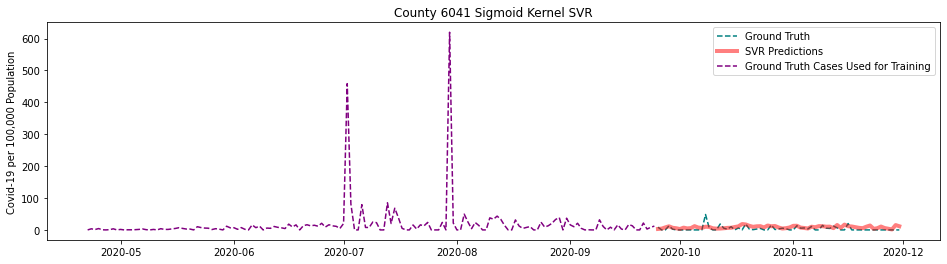

In [ ]:
County_6041_x, County_6041_y = get_county_data(final_df, 6041)
County_6041_X_train,County_6041_X_test,County_6041_y_train,County_6041_y_test,\
Train_Dates_6041,Test_Dates_6041 = data_splits(County_6041_x,County_6041_y)
County_6041_X_train_norm,County_6041_X_test_norm = norma(County_6041_X_train,County_6041_X_test)
Predictions_6041,MSE_6041 = SVR_pred_nopoly(County_6041_X_train_norm,County_6041_y_train,
                                            County_6041_X_test_norm,County_6041_y_test,'sigmoid',3.5)
print('The MSE of the Sigmoid Kernel SVR for County 6041 is',MSE_6041)
Predictions_and_Dates_6041 = plotdata(Test_Dates_6041,Predictions_6041,County_6041_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6041[0],abs(Predictions_and_Dates_6041[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6041[0],abs(Predictions_and_Dates_6041[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6041,County_6041_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6041 Sigmoid Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6041SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6059 is 215.43595634301352


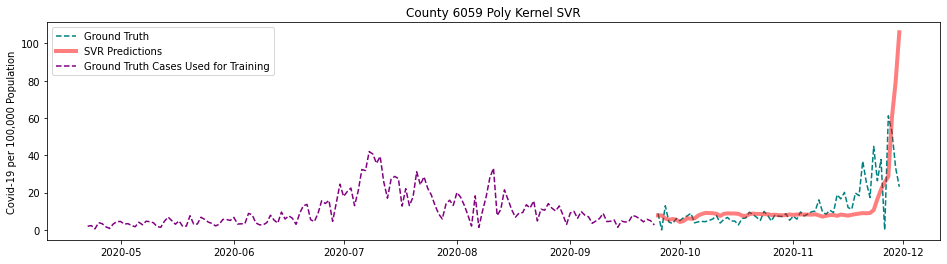

In [ ]:
County_6059_x, County_6059_y = get_county_data(final_df, 6059)
County_6059_X_train,County_6059_X_test,County_6059_y_train,County_6059_y_test,\
Train_Dates_6059,Test_Dates_6059 = data_splits(County_6059_x,County_6059_y)
County_6059_X_train_norm,County_6059_X_test_norm = norma(County_6059_X_train,County_6059_X_test)
Predictions_6059,MSE_6059 = SVR_pred_poly(County_6059_X_train_norm,County_6059_y_train,
                                         County_6059_X_test_norm,County_6059_y_test,3,1.0,0.0)
print('The MSE of the Poly Kernel SVR for County 6059 is',MSE_6059)
Predictions_and_Dates_6059 = plotdata(Test_Dates_6059,Predictions_6059,County_6059_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6059[0],abs(Predictions_and_Dates_6059[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6059[0],abs(Predictions_and_Dates_6059[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6059,County_6059_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6059 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6059SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6061 is 327.7151484834695


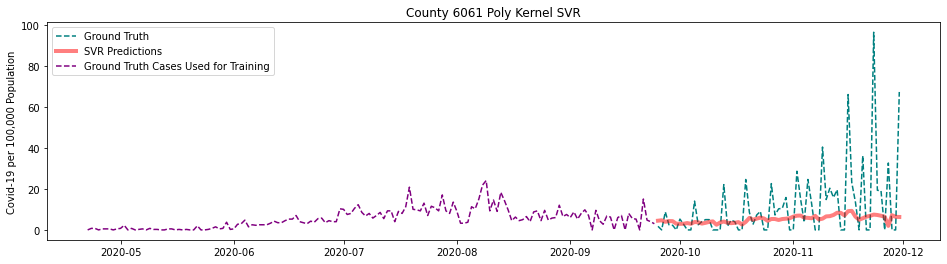

In [ ]:
County_6061_x, County_6061_y = get_county_data(final_df, 6061)
County_6061_X_train,County_6061_X_test,County_6061_y_train,County_6061_y_test,\
Train_Dates_6061,Test_Dates_6061 = data_splits(County_6061_x,County_6061_y)
County_6061_X_train_norm,County_6061_X_test_norm = norma(County_6061_X_train,County_6061_X_test)
Predictions_6061,MSE_6061 = SVR_pred_poly(County_6061_X_train_norm,County_6061_y_train,
                                         County_6061_X_test_norm,County_6061_y_test,2,1.8,0.1)
print('The MSE of the Poly Kernel SVR for County 6061 is',MSE_6061)
Predictions_and_Dates_6061 = plotdata(Test_Dates_6061,Predictions_6061,County_6061_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6061[0],Predictions_and_Dates_6061[1],
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6061[0],Predictions_and_Dates_6061[2],
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6061,County_6061_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6061 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6061SVR.jpg')
plt.show()

The MSE of the Sigmoid Kernel SVR for County 6065 is 316.7476635399617


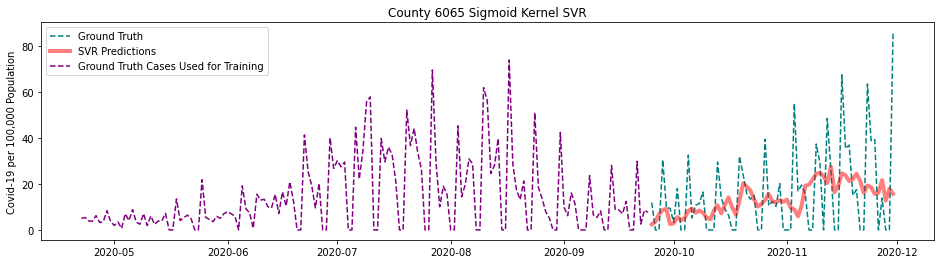

In [ ]:
County_6065_x, County_6065_y = get_county_data(final_df, 6065)
County_6065_X_train,County_6065_X_test,County_6065_y_train,County_6065_y_test,\
Train_Dates_6065,Test_Dates_6065 = data_splits(County_6065_x,County_6065_y)
County_6065_X_train_norm,County_6065_X_test_norm = norma(County_6065_X_train,County_6065_X_test)
Predictions_6065,MSE_6065 = SVR_pred_nopoly(County_6065_X_train_norm,County_6065_y_train,
                                           County_6065_X_test_norm,County_6065_y_test,'sigmoid',3.4)
print('The MSE of the Sigmoid Kernel SVR for County 6065 is',MSE_6065)
Predictions_and_Dates_6065 = plotdata(Test_Dates_6065,Predictions_6065,County_6065_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6065[0],abs(Predictions_and_Dates_6065[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6065[0],abs(Predictions_and_Dates_6065[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6065,County_6065_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6065 Sigmoid Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6065SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6067 is 1061.6397065503065


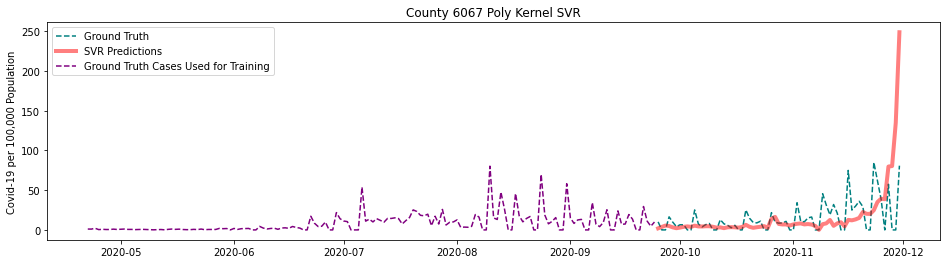

In [ ]:
County_6067_x, County_6067_y = get_county_data(final_df, 6067)
County_6067_X_train,County_6067_X_test,County_6067_y_train,County_6067_y_test,\
Train_Dates_6067,Test_Dates_6067 = data_splits(County_6067_x,County_6067_y)
County_6067_X_train_norm,County_6067_X_test_norm = norma(County_6067_X_train,County_6067_X_test)
Predictions_6067,MSE_6067 = SVR_pred_poly(County_6067_X_train_norm,County_6067_y_train,
                                         County_6067_X_test_norm,County_6067_y_test,4,4.9,0.6)
print('The MSE of the Poly Kernel SVR for County 6067 is',MSE_6067)
Predictions_and_Dates_6067 = plotdata(Test_Dates_6067,Predictions_6067,County_6067_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6067[0],abs(Predictions_and_Dates_6067[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6067[0],abs(Predictions_and_Dates_6067[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6067,County_6067_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6067 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6067SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6071 is 661.9093520640263


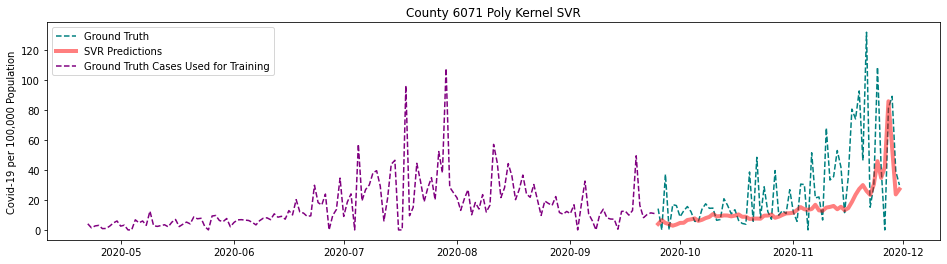

In [ ]:
County_6071_x, County_6071_y = get_county_data(final_df, 6071)
County_6071_X_train,County_6071_X_test,County_6071_y_train,County_6071_y_test,\
Train_Dates_6071,Test_Dates_6071 = data_splits(County_6071_x,County_6071_y)
County_6071_X_train_norm,County_6071_X_test_norm = norma(County_6071_X_train,County_6071_X_test)
Predictions_6071,MSE_6071 = SVR_pred_poly(County_6071_X_train_norm,
                                         County_6071_y_train,County_6071_X_test_norm,County_6071_y_test,3,1.9,0.9)
print('The MSE of the Poly Kernel SVR for County 6071 is',MSE_6071)
Predictions_and_Dates_6071 = plotdata(Test_Dates_6071,Predictions_6071,County_6071_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6071[0],abs(Predictions_and_Dates_6071[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6071[0],abs(Predictions_and_Dates_6071[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6071,County_6071_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6071 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6071SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6073 is 327.7025606914232


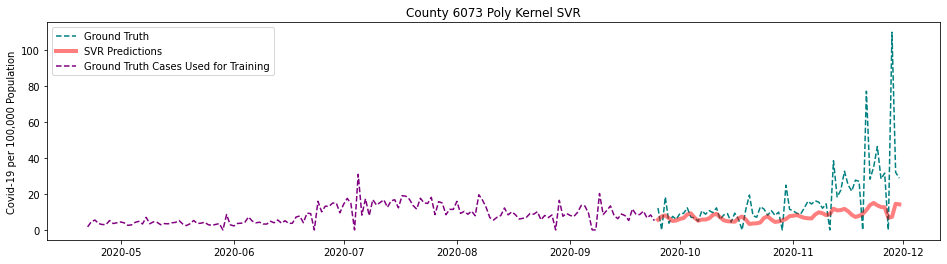

In [ ]:
County_6073_x, County_6073_y = get_county_data(final_df, 6073)
County_6073_X_train,County_6073_X_test,County_6073_y_train,County_6073_y_test,\
Train_Dates_6073,Test_Dates_6073 = data_splits(County_6073_x,County_6073_y)
County_6073_X_train_norm,County_6073_X_test_norm = norma(County_6073_X_train,County_6073_X_test)
Predictions_6073,MSE_6073 = SVR_pred_poly(County_6073_X_train_norm,
                                         County_6073_y_train,County_6073_X_test_norm,County_6073_y_test,2,1.2,0.9)
print('The MSE of the Poly Kernel SVR for County 6073 is',MSE_6073)
Predictions_and_Dates_6073 = plotdata(Test_Dates_6073,Predictions_6073,County_6073_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6073[0],abs(Predictions_and_Dates_6073[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6073[0],abs(Predictions_and_Dates_6073[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6073,County_6073_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6073 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6073SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6075 is 61.37458778040688


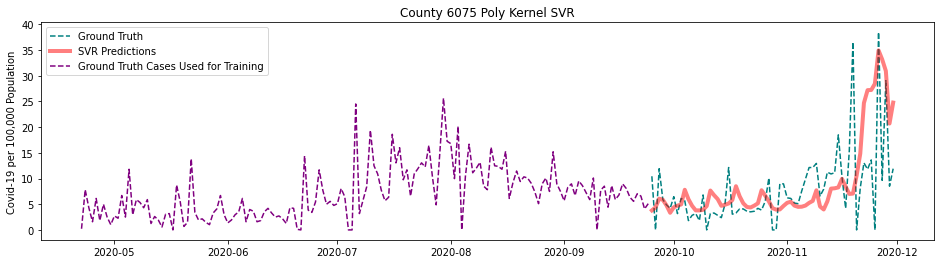

In [ ]:
County_6075_x, County_6075_y = get_county_data(final_df, 6075)
County_6075_X_train,County_6075_X_test,County_6075_y_train,County_6075_y_test,\
Train_Dates_6075,Test_Dates_6075 = data_splits(County_6075_x,County_6075_y)
County_6075_X_train_norm,County_6075_X_test_norm = norma(County_6075_X_train,County_6075_X_test)
Predictions_6075,MSE_6075 = SVR_pred_poly(County_6075_X_train_norm,County_6075_y_train,
                                         County_6075_X_test_norm,County_6075_y_test,3,1.1,0.9)
print('The MSE of the Poly Kernel SVR for County 6075 is',MSE_6075)
Predictions_and_Dates_6075 = plotdata(Test_Dates_6075,Predictions_6075,County_6075_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6075[0],abs(Predictions_and_Dates_6075[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6075[0],abs(Predictions_and_Dates_6075[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6075,County_6075_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6075 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6075SVR.jpg')
plt.show()

The MSE of the rbf Kernel SVR for County 6079 is 503.7342189016051


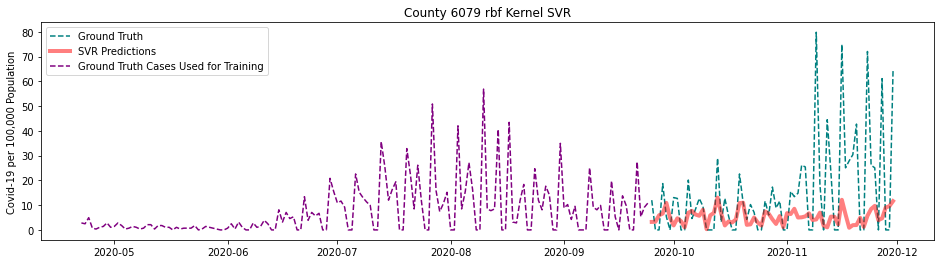

In [ ]:
County_6079_x, County_6079_y = get_county_data(final_df, 6079)
County_6079_X_train,County_6079_X_test,County_6079_y_train,County_6079_y_test,\
Train_Dates_6079,Test_Dates_6079 = data_splits(County_6079_x,County_6079_y)
County_6079_X_train_norm,County_6079_X_test_norm = norma(County_6079_X_train,County_6079_X_test)
Predictions_6079,MSE_6079 = SVR_pred_poly(County_6079_X_train_norm,County_6079_y_train,
                                         County_6079_X_test_norm,County_6079_y_test,2,4.9,0.6)
print('The MSE of the rbf Kernel SVR for County 6079 is',MSE_6079)
Predictions_and_Dates_6079 = plotdata(Test_Dates_6079,Predictions_6079,County_6079_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6079[0],abs(Predictions_and_Dates_6079[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6079[0],abs(Predictions_and_Dates_6079[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6079,County_6079_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6079 rbf Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6079SVR.jpg')
plt.show()

The MSE of the Sigmoid Kernel SVR for County 6081 is 106.41729518438848


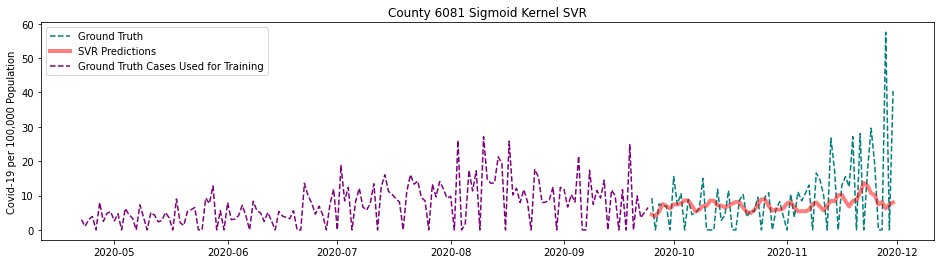

In [ ]:
County_6081_x, County_6081_y = get_county_data(final_df, 6081)
County_6081_X_train,County_6081_X_test,County_6081_y_train,County_6081_y_test,\
Train_Dates_6081,Test_Dates_6081 = data_splits(County_6081_x,County_6081_y)
County_6081_X_train_norm,County_6081_X_test_norm = norma(County_6081_X_train,County_6081_X_test)
Predictions_6081,MSE_6081 = SVR_pred_nopoly(County_6081_X_train_norm,County_6081_y_train,
                                           County_6081_X_test_norm,County_6081_y_test,'sigmoid',1.0)
print('The MSE of the Sigmoid Kernel SVR for County 6081 is',MSE_6081)
Predictions_and_Dates_6081 = plotdata(Test_Dates_6081,Predictions_6081,County_6081_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6081[0],abs(Predictions_and_Dates_6081[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6081[0],abs(Predictions_and_Dates_6081[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6081,County_6081_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6081 Sigmoid Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6081SVR.jpg')
plt.show()

The MSE of the rbf Kernel SVR for County 6085 is 106.29765927610175


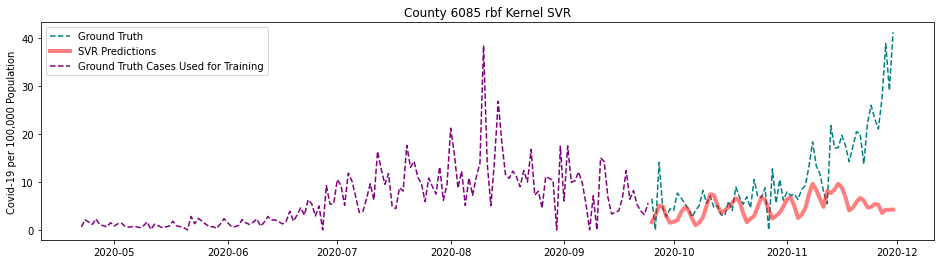

In [ ]:
County_6085_x, County_6085_y = get_county_data(final_df, 6085)
County_6085_X_train,County_6085_X_test,County_6085_y_train,County_6085_y_test,\
Train_Dates_6085,Test_Dates_6085 = data_splits(County_6085_x,County_6085_y)
County_6085_X_train_norm,County_6085_X_test_norm = norma(County_6085_X_train,County_6085_X_test)
Predictions_6085,MSE_6085 = SVR_pred_nopoly(County_6085_X_train_norm,County_6085_y_train,
                                           County_6085_X_test_norm,County_6085_y_test,'rbf',1.6)
print('The MSE of the rbf Kernel SVR for County 6085 is',MSE_6085)
Predictions_and_Dates_6085 = plotdata(Test_Dates_6085,Predictions_6085,County_6085_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6085[0],abs(Predictions_and_Dates_6085[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6085[0],abs(Predictions_and_Dates_6085[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6085,County_6085_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6085 rbf Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6085SVR.jpg')
plt.show()

The MSE of the Poly Kernel SVR for County 6099 is 718.9621009227276


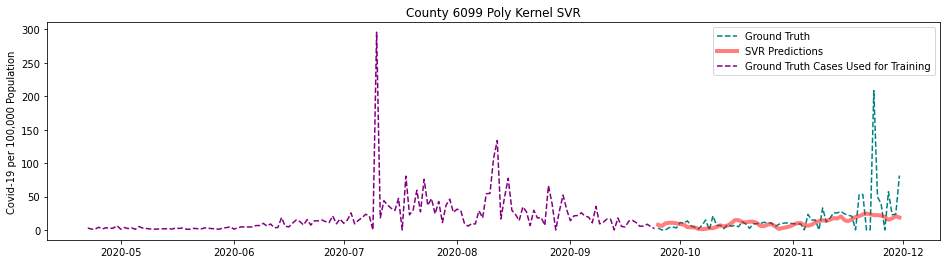

In [ ]:
County_6099_x, County_6099_y = get_county_data(final_df, 6099)
County_6099_X_train,County_6099_X_test,County_6099_y_train,County_6099_y_test,\
Train_Dates_6099,Test_Dates_6099 = data_splits(County_6099_x,County_6099_y)
County_6099_X_train_norm,County_6099_X_test_norm = norma(County_6099_X_train,County_6099_X_test)
Predictions_6099,MSE_6099 = SVR_pred_nopoly(County_6099_X_train_norm,County_6099_y_train,
                                           County_6099_X_test_norm,County_6099_y_test,'rbf',3.7)
print('The MSE of the Poly Kernel SVR for County 6099 is',MSE_6099)
Predictions_and_Dates_6099 = plotdata(Test_Dates_6099,Predictions_6099,County_6099_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6099[0],abs(Predictions_and_Dates_6099[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6099[0],abs(Predictions_and_Dates_6099[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6099,County_6099_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6099 Poly Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6099SVR.jpg')
plt.show()

The MSE of the rbf Kernel SVR for County 6111 is 816.0156999372598


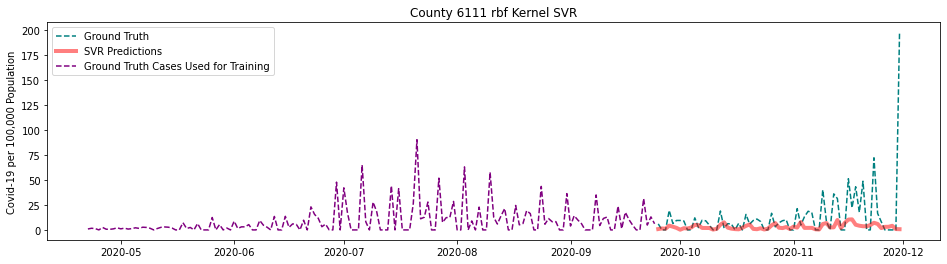

In [ ]:
County_6111_x, County_6111_y = get_county_data(final_df, 6111)
County_6111_X_train,County_6111_X_test,County_6111_y_train,County_6111_y_test,\
Train_Dates_6111,Test_Dates_6111 = data_splits(County_6111_x,County_6111_y)
County_6111_X_train_norm,County_6111_X_test_norm = norma(County_6111_X_train,County_6111_X_test)
Predictions_6111,MSE_6111 = SVR_pred_nopoly(County_6111_X_train_norm,County_6111_y_train,
                                           County_6111_X_test_norm,County_6111_y_test,'sigmoid',2.3)
print('The MSE of the rbf Kernel SVR for County 6111 is',MSE_6111)
Predictions_and_Dates_6111 = plotdata(Test_Dates_6111,Predictions_6111,County_6111_y_test)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(Predictions_and_Dates_6111[0],abs(Predictions_and_Dates_6111[1]),
        color='teal',linestyle='dashed',label='Ground Truth')
ax.plot(Predictions_and_Dates_6111[0],abs(Predictions_and_Dates_6111[2]),
        color='red',alpha=0.5,linewidth=4,label='SVR Predictions')
ax.plot(Train_Dates_6111,County_6111_y_train,color='purple',
        linestyle='dashed',label='Ground Truth Cases Used for Training')
plt.title('County 6111 rbf Kernel SVR')
plt.ylabel('Covid-19 per 100,000 Population')
plt.legend()
plt.savefig('County6111SVR.jpg')
plt.show()